<div align="center" class="alert alert-info" role="alert">
    <h1>
        Анализ продаж видеоигр<br>
        <small class="text-muted">Сборный проект-1 по специализации "Data Science"</small>
    </h1>
    <h3>аналитический проект, демонстрирующий навыки препроцессинга <br> и исследовательного анализа данных и проверки статистических гипотез</h3>
</div>

<div align="right" class="alert alert-info" role="alert">
    <h3>Евгения Хомякова, 2020/11</h3>
</div>

<a name="table_of_contents"></a>

### Оглавление

0. [Импорт библиотек  и данных, определение функций](#import)
1. [Предобработка данных](#preproc)
2. [Исследовательский анализ данных](#eda)
    * [Анализ количества проданных в разные годы игр](#total_sales_yearly)
    * [Анализ количества проданных в разные года игр для самых популярных платформ за период 1990-2016](#total_sales_yearly_top_platform)
    * [Анализ количества проданных в разные года игр для современных платформ](#total_sales_yearly_platform_actual)
    * [Анализ влияния отзывов пользователей и критиков на продажи игр современных платформ](#scores)
    * [Анализ продаваемости игр разных жанров](#genres)
 
 
3. [Составление "портретов пользователей"  в регионах EU, NA, JP](#portret)
    * [Сравнение популярности и продаваемости платформ](#platforms)
    * [Выявление популярнейших игр](#games)
    * [Сравнение популярности и продаваемости жанров](#region_genres)
    * [Сравнение популярности и продаваемости игр различных возрастных категорий](#esrb)

4. [Проверка гипотез](#tests)
5. [Общие выводы](#conclusions)

### Описание проекта

**Данные**: исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

**Задача**: выявить определяющие успешность игры закономерности.

**Цель**: в будущем возможно будет сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### Описание данных
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

<a name="import"></a>
## 0. Импорт библиотек  и данных, определение функций

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from tqdm import tqdm
from termcolor import colored

from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
colors = ['darkorange', 'grey', 'crimson', 'turquoise']

sns.set_palette('Paired')
sns.set_style('whitegrid',
              {'axes.facecolor': '1',
               'axes.edgecolor': '0.1',
               'axes.labelcolor': '0.2',
               'text.color': '0.2',
               'xtick.color': '0.2',
               'ytick.color': '0.2',
               'grid.color': '0.7',
               'figure.facecolor': '0.95',}
             )

sns.set_context('notebook', font_scale=1.3)


In [3]:
plt.rcParams.update({
    'legend.fancybox': True,
    'legend.fontsize': 14,
    'legend.framealpha': 0.8,
    'legend.frameon': True,
    'legend.shadow': True,
    'legend.title_fontsize': 15,
    'figure.figsize': (10, 6)
})

In [4]:
def clean_outlierts(data, col_name):
    '''
    удаляет из датафрейма data строки, содержание в col_name выбросы
    возвращает измененный датафрейм
    '''
    q075 = data[col_name].quantile(0.75)
    q025 = data[col_name].quantile(0.25)
    upper = q075 + 1.5*(q075 - q025)
    lower = max(0, q075 - 1.5*(q075 - q025))
    return data[(lower <= data[col_name]) & (data[col_name] <= upper)]
   
def plot_sales_boxplot(data=None, x=None, y=None, order=None, title=None):
    plt.figure(figsize=(12,5))
    sns.boxplot(data=data, x=x, y=y, width=0.6, order=order)
    plt.xlabel('sales, mln copies')
    plt.suptitle(title)
    plt.show()
    
def bold(str):
    return '\033[1m' + str + "\033[0;0m"

### Загрузка датасета

In [5]:
# посмотрим на общую информацию об исходном датафрейме
data = pd.read_csv('games.csv')

In [6]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Датафрейм выглядит понятно: 16715 записей о видеоиграх, есть пропущенные значения и некорректные типы столбцов.

[вернуться к оглавлению](#table_of_contents)

<a name="preproc"></a>

## 1. Предобработка данных

### Приведение столбцов к нижнему регистру

In [8]:
# приведение столбцов к нижнему регистру
data.columns = [col_name.lower() for col_name in data.columns]
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Заполнение пропущенных значений и поиск дубликатов

In [9]:
# сколько в каких столбцах есть пропусков
data.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Игры, для которых не указано название *(они же содержат пропуски и в других колонках, например `'genre'`)*, смело выбрасываем, так как они явно ошибочно к нам попали. Аналогично поступаем со строками без значения `'year_of_release'`, которые можно было бы заполнить через поиск в интернете, но это трудоемко, игра не стоит свеч, удаляем! Скорее всего, это ошибка выгрузки данных, потому что год релиза не может не существовать в принципе.

In [10]:
data = data.dropna(subset=['name', 'year_of_release'])

In [11]:
data.isnull().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating             6676
dtype: int64

Рейтинги заполнять не будем, оставим как есть. Рейтинги могли остаться пустыми, если эти игры никто никогда не оценивал, что вполне может быть для новых игр. Но скорее всего, это ошибка выгрузки.

Так же надо не забыть удалить дубликаты, если они есть:

In [12]:
data.duplicated().sum()

0

А их и нет. Посмотрим, все ли названия игр уникальны:

In [13]:
data.name.nunique() == len(data)

False

Оп! И какие же повторяются?

In [14]:
data.name.value_counts()[data.name.value_counts() > 1]

Need for Speed: Most Wanted                      12
FIFA 14                                           9
LEGO Marvel Super Heroes                          9
Ratatouille                                       9
Madden NFL 07                                     8
                                                 ..
Sengoku Basara: Sanada Yukimura-Den               2
Judge Dredd: Dredd Vs Death                       2
Metal Gear Solid V: The Definitive Experience     2
Bodycount                                         2
College Hoops 2K7                                 2
Name: name, Length: 2748, dtype: int64

При этом дубликатов у нас как бы нет. Посмотрим поближе на повторяющиеся имена:

In [15]:
data[data['name'] == 'Need for Speed: Most Wanted']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,Need for Speed: Most Wanted,PS3,2012.0,Racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1998,Need for Speed: Most Wanted,XB,2005.0,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T
2048,Need for Speed: Most Wanted,PSV,2012.0,Racing,0.33,0.45,0.01,0.22,NaN,NaN,NaN
3581,Need for Speed: Most Wanted,GC,2005.0,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6273,Need for Speed: Most Wanted,WiiU,2013.0,Racing,0.13,0.12,0.00,0.02,NaN,NaN,NaN
6410,Need for Speed: Most Wanted,DS,2005.0,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E


Все ясно, имена одинаковые, но платформы/год выпуска (обновление?) разные. Оставляем все как есть.

### Преобразование типов данных

In [16]:
data.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

Некорректные типы у колонок `'year_of_release'` (=> int) и `'user_score'` (=> float).

In [17]:
data['year_of_release'] = data['year_of_release'].astype('int')

#### Аббревиатура tbd
Содержится в столбце `user_score`, причем ее довольно много. Она означает 'to be decided', то есть в базе еще недостаточно оценок, чтобы выставить рейтинг. Эти значения можно заменить на np.nan и сменить тип колонки на `float`:

In [18]:
data.user_score.value_counts().head()

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
Name: user_score, dtype: int64

In [19]:
data['user_score'] = data['user_score'].replace('tbd', np.nan).astype('float')

In [20]:
data.dtypes

name                object
platform            object
year_of_release      int32
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
dtype: object

Теперь все колонки имеют адекватный тип данных.

### Подсчет суммарных продаж

Добавим столбец - сумму всех продаж (млн.копий) по всем регионам

In [21]:
data['total_sales'] = data[['na_sales', 'eu_sales','jp_sales', 'other_sales']].sum(axis=1)

In [22]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


[вернуться к оглавлению](#table_of_contents)

<a name="eda"></a>
## 2. Исследовательский анализ данных

<a name="total_sales_yearly"></a>
### Анализ количества проданных в разные годы игр

Сгруппируем игры по году выпуска, подсчитывая суммарное количество выпущенных в каждый год игр:

In [23]:
data_grouped_by_year = data.pivot_table(index='year_of_release', values='name', aggfunc='count')
data_grouped_by_year.columns = ['count']
data_grouped_by_year.T

year_of_release,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
count,9,46,36,17,14,14,21,16,15,17,16,41,43,60,121,219,263,289,379,338,350,482,829,775,762,939,1006,1197,1427,1426,1255,1136,653,544,581,606,502


Получится вот такой временной ряд. Изобразим его на графике:

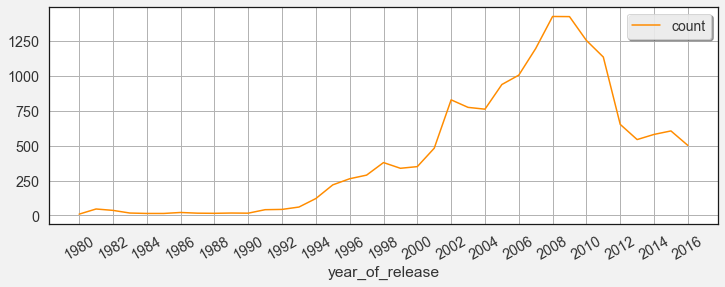

In [24]:
data_grouped_by_year.plot(c=colors[0], figsize=(12,4))
plt.xticks(np.arange(1980, 2017, 2), rotation=30)
plt.show()

In [25]:
print('Год в который выпустили наибольшее число игр - ', data_grouped_by_year['count'].idxmax())

Год в который выпустили наибольшее число игр -  2008


До 1990 года количество выпускаемых игр было незначительным, зато потом наблюдаем активный рост числа игр в год, который достигает максимума в 2008 году, а потом снова идет на спад. Отсечем данные за период до 1990 года, так как они не информативны для построения прогнозов:

In [26]:
data = data.query('year_of_release >= 1990')

[вернуться к оглавлению](#table_of_contents)

<a name="total_sales_yearly_top_platform"></a>
### Анализ количества проданных в разные года игр для *самых популярных* платформ за период 1990-2016

Сгруппируем данные  по платформам, подсчитывая суммарное число продаж на каждой из них за период 1990-2016:

In [27]:
# группируем по платформе, считая суммарное число продаж
data_grouped_by_platform = data\
                                .pivot_table(index='platform', values='total_sales', aggfunc='sum')\
                                .sort_values(by='total_sales', ascending=False)
data_grouped_by_platform.head(10)

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.76
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


Возьмем 7 платформ, игры для которых продавались больше всего за период 1990-2016 и построим для них распределение суммарных продаж по годам:

In [28]:
top_platforms = data_grouped_by_platform.head(7).index.tolist()
top_platforms

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4']

In [29]:
# группируем по платформе и году, считая суммарное число продаж
top_platforms_yearly_sales = data.query('platform in @top_platforms') \
                                                    .pivot_table(index=['year_of_release', 'platform'],
                                                                 values='total_sales', aggfunc='sum') \
                                                    .reset_index()
top_platforms_yearly_sales.head(10)

,year_of_release,platform,total_sales
0,1994,PS,6.03
1,1995,PS,35.96
2,1996,PS,94.70
3,1997,PS,136.17
4,1998,PS,169.49
5,1999,PS,144.53
6,2000,PS,96.37
7,2000,PS2,39.17
8,2001,PS,35.59
9,2001,PS2,166.43


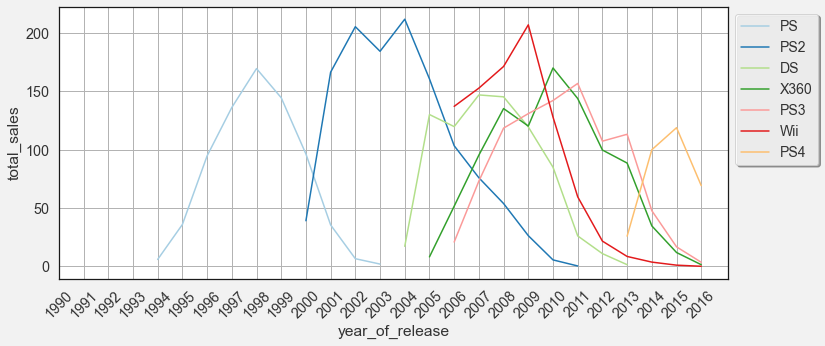

In [30]:
plt.figure(figsize=(12,5))
sns.lineplot(data=top_platforms_yearly_sales,
             x='year_of_release', y='total_sales', hue='platform')
plt.xticks(np.arange(1990, 2017, 1), rotation=45)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Видно, как "угасают" все когда-то популярные платформы: можно сказать, что в среднем платформа остается востребованной в течение 10 лет.

Далее будем использовать данные с 2000 по 2016 включительно:

In [31]:
data = data.query('year_of_release >= 2000')

[вернуться к оглавлению](#table_of_contents)

<a name="total_sales_yearly_platform_actual"></a>
### Анализ количества проданных в разные года игр для *современных* платформ

Посмотрим на суммарные продажи игр для разных платформ за выбранный период (2000-2016):

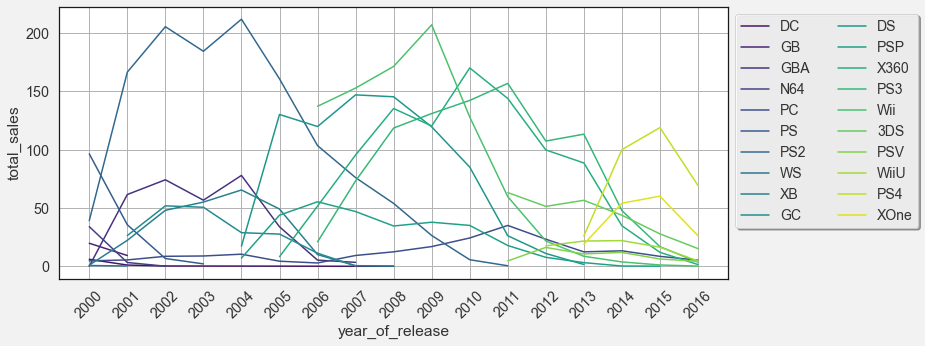

In [32]:
plt.figure(figsize=(12,5))
sns.lineplot(data=data \
             .pivot_table(index=['year_of_release', 'platform'],
                          values='total_sales', aggfunc='sum') \
             .reset_index(),
             x='year_of_release', y='total_sales', hue='platform', palette='viridis')
plt.xticks(np.arange(2000, 2017, 1), rotation=45)
plt.legend(bbox_to_anchor=(1, 1), ncol=2)
plt.show()

Можно убрать платформы, которые затухли полностью до 2011 года, оставим только современные - получим **данные для современных платформ**, которые и будем анализировать дальше. Выберем по графику, какие платформы нужно удалить:

In [33]:
dead_platforms = data.query('year_of_release == 2000').platform.unique().tolist() + ['GC']
dead_platforms

['GB', 'PS', 'PS2', 'N64', 'PC', 'DC', 'XB', 'WS', 'GBA', 'GC']

In [34]:
data_actual = data.query('platform not in @dead_platforms')

*Будем считать отобранные платформы* **современными**. Посмотрим, как менялись годовые продажи игр для современных платформ с течением времени:

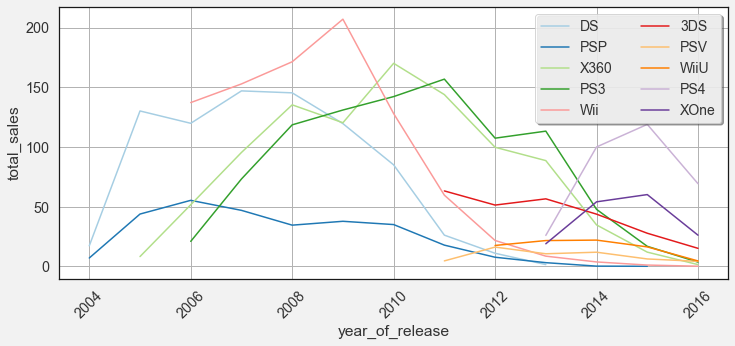

In [35]:
plt.figure(figsize=(12,5))
sns.lineplot(data=data_actual \
             .pivot_table(index=['year_of_release', 'platform'],
                          values='total_sales', aggfunc='sum') \
             .reset_index(),
             x='year_of_release', y='total_sales', hue='platform')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1, 1), ncol=2)
plt.show()

Все современные платформы падают по продажам, кроме **PS4** и **XOne** (в 2016 году данные не полные, как было сказано выше) - их будем считать **перспективными**.

**Популярность** - позиция в рейтинге по суммарным продажам. Она определяется не только числом проданных копий, но и в принципе количеством игр, которые выпустила платформа. Соответственно более старые платформы могут иметь более высокую популярность в том числе потому, что существуют на рынке дольше. Однако **продаваемость**, кажется, лучше подходит для составления рейтингов, так как нормировка на количество игр отражает сколько в среднем копий игры продается на каждой платформе. Кроме того, при построении такого рейтинга не учитывается стоимость каждого конкретного экземпляра, поэтому строго говоря, судить о прибыльности можно только косвенно.

Будем составлять рейтинги обоими способами и делать выводы.

In [36]:
# группируем данные по платформе, подсчитывая суммарные продажи игр (популярность)
# и среднее число проданных копий (продаваемость)
data_grouped_by_platform = data_actual.pivot_table(index='platform', values='total_sales', aggfunc=['sum', 'mean'])
data_grouped_by_platform.columns = ['total_sales', 'game_mean_sales']

In [37]:
# рейтинг современных платформ по популярности
print(data_grouped_by_platform.sort_values(by='total_sales', ascending=False).index.tolist())
data_grouped_by_platform.sort_values(by='total_sales', ascending=False)

['X360', 'PS3', 'Wii', 'DS', 'PS4', 'PSP', '3DS', 'XOne', 'WiiU', 'PSV']


,total_sales,game_mean_sales
platform,,
X360,961.24,0.780227
PS3,931.34,0.713124
Wii,891.18,0.692986
DS,802.76,0.378660
PS4,314.14,0.801378
PSP,289.53,0.242691
3DS,257.81,0.503535
XOne,159.32,0.645020
WiiU,82.19,0.559116


In [38]:
# рейтинг современных платформ по продаваемости
data_grouped_by_platform.sort_values(by='game_mean_sales', ascending=False)

,total_sales,game_mean_sales
platform,,
PS4,314.14,0.801378
X360,961.24,0.780227
PS3,931.34,0.713124
Wii,891.18,0.692986
XOne,159.32,0.645020
WiiU,82.19,0.559116
3DS,257.81,0.503535
DS,802.76,0.378660
PSP,289.53,0.242691


Из таблиц видно, что топовые по суммарным продажам платформы - **X360**, **PS3**, **Wii**. Однако в рейтинге продаваемости лидирует развивающаяся перспективаня платформа **PS4** (мы ее определили таковой выше) - PS4 в среднем продает 0.8 млн копий игры.

*Хотя, вероятно, это очень корректно сравнивать затухающие и развивающиеся платформы.*

Проверим эти наблюдения на боксплотах.

In [39]:
# строить боксплоты будем в порядке убывания продаваемости разных платформ
platform_order = data_grouped_by_platform.sort_values(by='game_mean_sales', ascending=False).index.tolist()

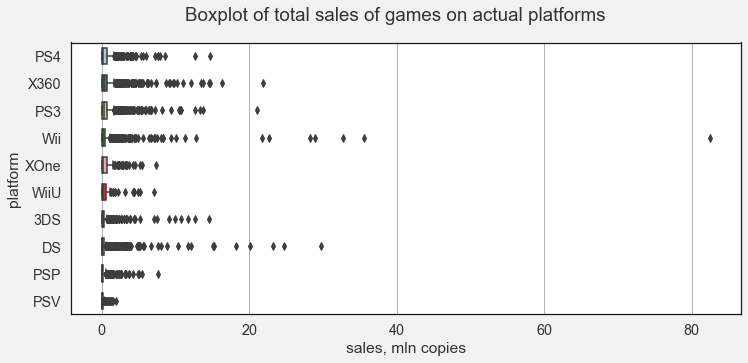

In [40]:
# строим бохплоты для суммарных продаж разных игр для различных современных платформ
# сортировка платформ на графике - по убыванию продаваемости игр
plot_sales_boxplot(data=data_actual, x='total_sales', y='platform', order=platform_order,
                   title='Boxplot of total sales of games on actual platforms')

Какая-то игра платформы Wii имеет рекордное число продаж - более 80 млн копий. Итересно, что это за игра:

In [41]:
data_actual.sort_values(by='total_sales', ascending=False).head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91


4 из топ-5 продаваемых игр в мире - на платформе Wii. Первое место (Wii Sports) более, чем в два раза превышает по продажам второе место (Mario Kart Wii). **Wii Sports** - самая популярная игра современности! :)

Удалим выбросы, чтобы получше рассмотреть боксплоты:

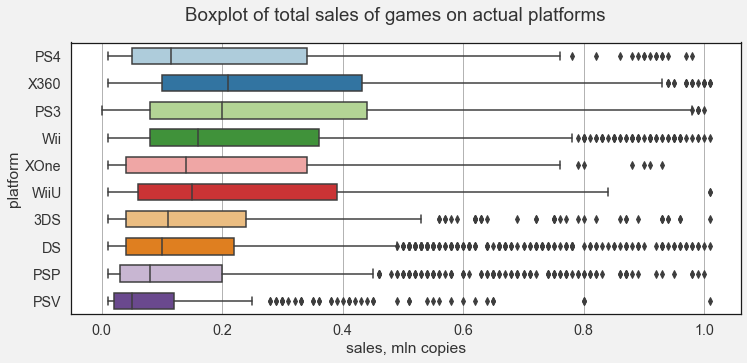

In [42]:
# строим бохплоты для суммарных продаж разных игр для различных современных платформ
# сортировка платформ на графике - по убыванию продаваемости игр
plot_sales_boxplot(data=clean_outlierts(data_actual, 'total_sales'),
                   x='total_sales', y='platform', order=platform_order,
                   title='Boxplot of total sales of games on actual platforms')

Описанные выше наблюдения подтвержаются боксплотами.

[вернуться к оглавлению](#table_of_contents)

<a name="scores"></a>
### Анализ влияния отзывов пользователей и критиков на продажи игр современных платформ

Посмотрим, как вообще распределены значения колонок с отзывами:

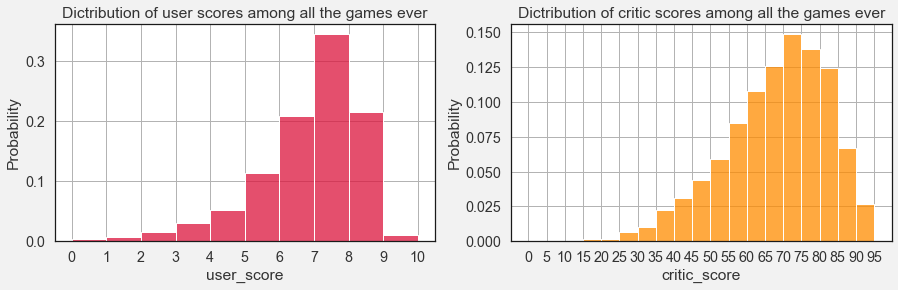

In [43]:
fig, ax = plt.subplots(1,2, figsize=(15,4))

sns.histplot(data=data_actual, x='user_score', bins=range(0,11), stat='probability', color=colors[2], ax=ax[0])
ax[0].set_xticks(range(0,11))
ax[0].set_title('Dictribution of user scores among all the games ever')

sns.histplot(data=data_actual, x='critic_score', bins=range(0,100,5), stat='probability', color=colors[0], ax=ax[1])
ax[1].set_xticks(range(0,100,5))
ax[1].set_title('Dictribution of critic scores among all the games ever')

plt.show()

Распределения обеих колонок - скошеные. Довольно много игр с пользовательским рейтингом 7+ и оценкой критиков за 70. Выпускаемые игры, в основном, нравятся заинтересованным в них людям.

Построим для каждой современной платформы диаграмы рассеяния (отзывы-суммарные продажи) и посчитаем коэффициенты корреляции обеих колонок с отзывами с суммарными продажами:

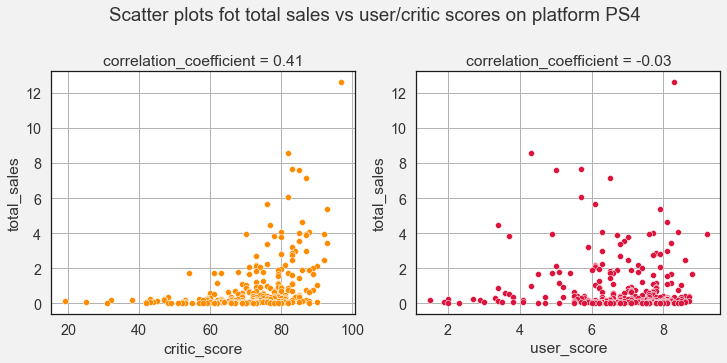

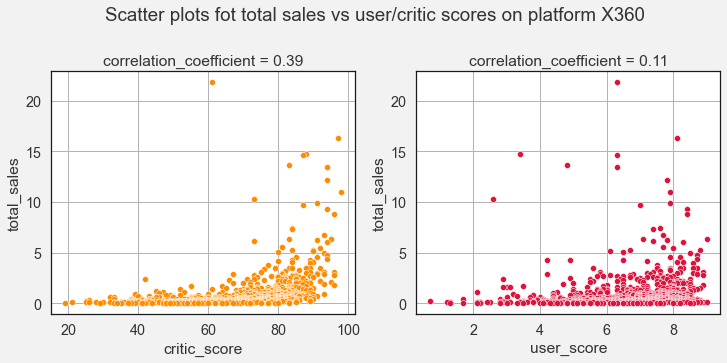

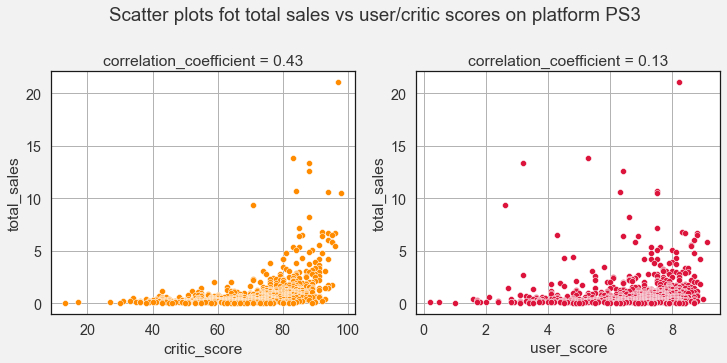

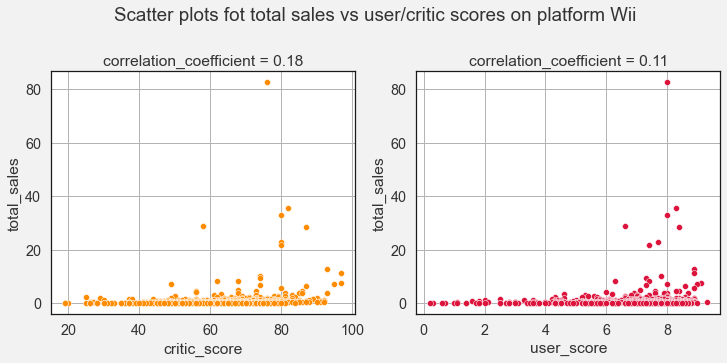

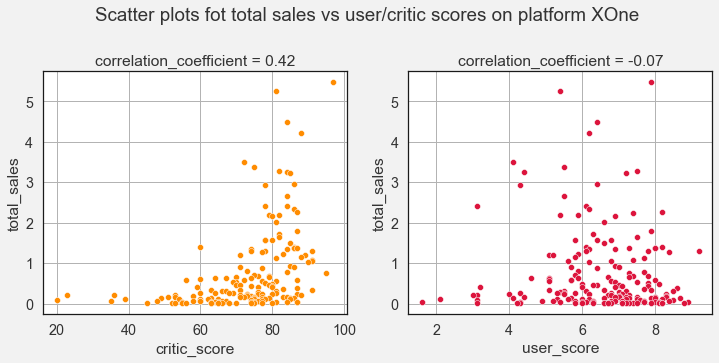

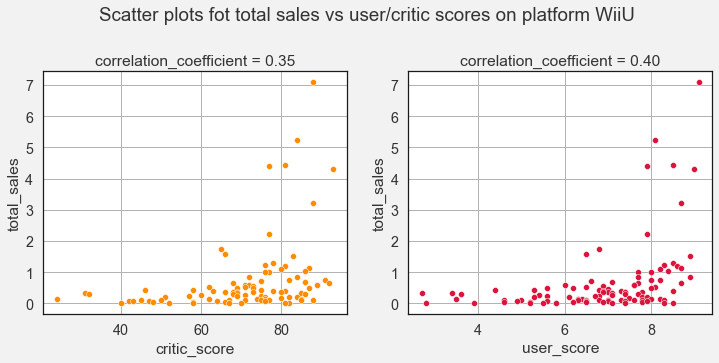

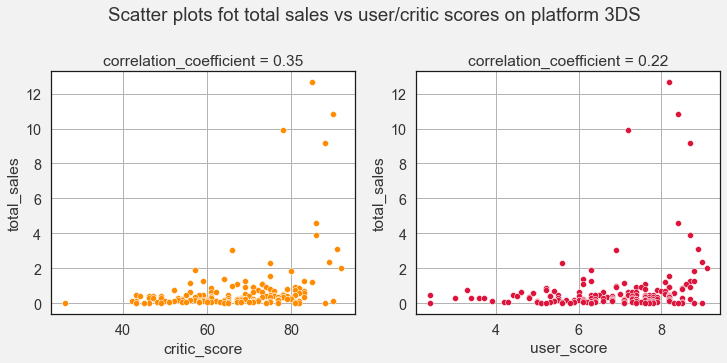

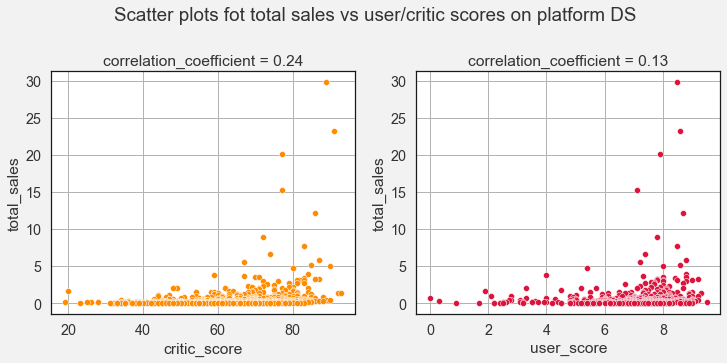

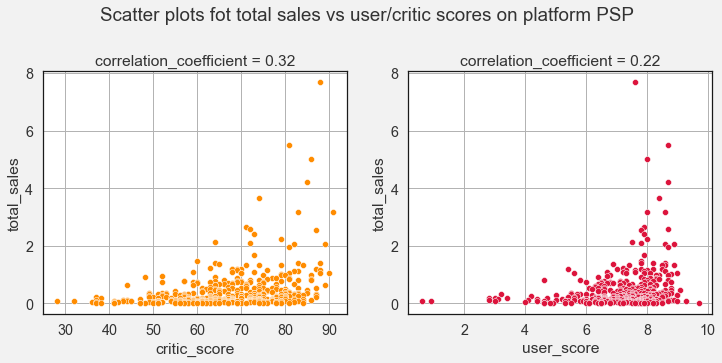

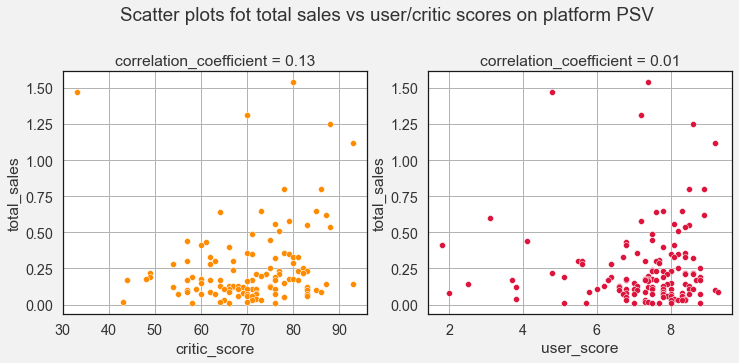

In [44]:
for platform in platform_order:
    data_temp = data_actual.query('platform == @platform')
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    
    sns.scatterplot(data=data_temp,
                    x='critic_score', y='total_sales',
                    ax=ax[0], color=colors[0])
    ax[0].set_title('correlation_coefficient = {:.2f}'.format(data_temp['total_sales'].corr(data_temp['critic_score']),
                                                              pad=10))
    sns.scatterplot(data=data_temp,
                    x='user_score', y='total_sales',
                    ax=ax[1], color=colors[2])
    plt.suptitle('Scatter plots fot total sales vs user/critic scores on platform '+platform)
    ax[1].set_title('correlation_coefficient = {:.2f}'.format(data_temp['total_sales'].corr(data_temp['user_score']),
                                                              pad=10))
    
    plt.subplots_adjust(top=0.8)
    plt.show()

Посмотрим на коэффициенты корреляции для разных платформ поближе:

In [45]:
critic_corrs = []
user_corrs = []
for platform in data_actual['platform'].unique():
    data_temp = data_actual.query('platform == @platform')
    critic_corrs.append(data_temp['total_sales'].corr(data_temp['critic_score']))
    user_corrs.append(data_temp['total_sales'].corr(data_temp['user_score']))

corr_coefs = pd.DataFrame({'critic_sales_corr': critic_corrs,
                           'user_sales_corr': user_corrs}, index=data_actual['platform'].unique())  
np.round(corr_coefs, 2)

,critic_sales_corr,user_sales_corr
Wii,0.18,0.11
DS,0.24,0.13
X360,0.39,0.11
PS3,0.43,0.13
PS4,0.41,-0.03
3DS,0.35,0.22
PSP,0.32,0.22
XOne,0.42,-0.07
WiiU,0.35,0.40
PSV,0.13,0.01


In [46]:
np.round(corr_coefs.mean(axis=0), 2)

critic_sales_corr    0.32
user_sales_corr      0.12
dtype: float64

Среди оценок критиков налюдается тренд на увеличение продаж при увеличении оценки (на то они и критики), а среди пользователей ситуация более случайная (на то они и пользователи). Это подтверждается коэффициентами корреляции, например для платформы **X360** коэффициенты корреляции соедующие: 0.4 для продаж и оценок критиков, 0.1 для продаж и оценок пользователей.

Таким образом, корреляции (прямая линейная зависимость) продаж и оценки критиков немного сильнее, чем продаж и оценки пользователей.

[вернуться к оглавлению](#table_of_contents)

<a name="genres"></a>

### Анализ продаваемости игр разных жанров

In [47]:
# группируем данные по жанру, подсчитывая суммарные продажи игр каждого жанра
# и среднее число копий для каждой игры жанра (продаваемость)
data_grouped_by_genre = data_actual.pivot_table(index='genre', values='total_sales', aggfunc=['sum', 'mean'])
data_grouped_by_genre.columns = ['total_sales', 'game_mean_sales']

In [48]:
# рейтинг жанров по суммарным продажам
data_grouped_by_genre.sort_values(by='total_sales', ascending=False)

,total_sales,game_mean_sales
genre,,
Action,1041.91,0.496857
Sports,723.21,0.661674
Shooter,681.09,1.150490
Misc,539.23,0.470122
Role-Playing,470.56,0.548438
Racing,315.04,0.664641
Platform,287.59,0.915892
Simulation,224.72,0.449440
Fighting,171.15,0.487607


Исходя из сортированного по суммарным продажам списка жанров **самые распространенные жанры** - **Action**, **Sports** и **Shooter** весьма соответствует правде, потому что даже я, человек, далекий от компьтерных игр, могу привести пример на каждый из этих жанров :) ). Однако, спортивные и экшен игры берут количеством (разных игр), это следует из таблицы ниже:

In [49]:
# рейтинг жанров по продаваемости
data_grouped_by_genre.sort_values(by='game_mean_sales', ascending=False)

,total_sales,game_mean_sales
genre,,
Shooter,681.09,1.150490
Platform,287.59,0.915892
Racing,315.04,0.664641
Sports,723.21,0.661674
Role-Playing,470.56,0.548438
Action,1041.91,0.496857
Fighting,171.15,0.487607
Misc,539.23,0.470122
Simulation,224.72,0.449440


Из этой таблицы видно, что **по среднему число проданных копий лидируют** (лучшие по продаваемости) стрелялки (**Shooter**), бродилки (**Platform**) и гонки (**Racing**). То есть хоть их меньше разных, но продаваемость у них больше. 

Стратегии (**Strategy**), головоломки (**Puzzle**) и прилючения (квесты) (**Adventure**) в обоих рейтингах занмают **последние строчки**.

Проверим эти наблюдения на боксплотах.

In [50]:
# строить боксплоты будем в порядке убывания продаваемости жанров
genre_order = data_grouped_by_genre.sort_values(by='game_mean_sales', ascending=False).index.tolist()

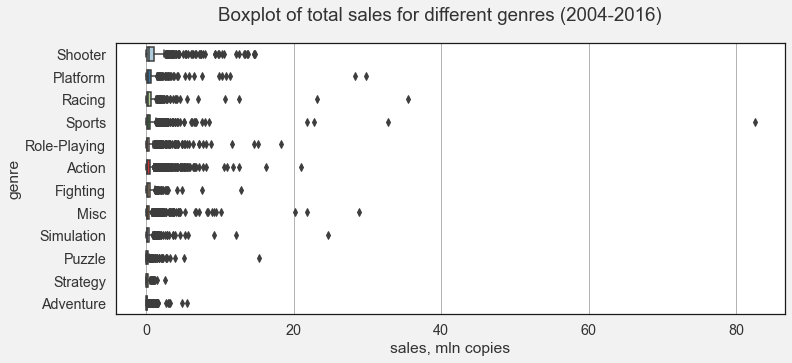

In [51]:
# строим бохплоты для суммарных продаж разных игр для различных современных платформ
# сортировка жанров на графике - по убыванию продаваемости жанров за актуальный период
plot_sales_boxplot(data=data_actual, x='total_sales', y='genre', order=genre_order,
                  title='Boxplot of total sales for different genres (2004-2016)')

Удалим выбросы, чтобы получше рассмотреть боксплоты:

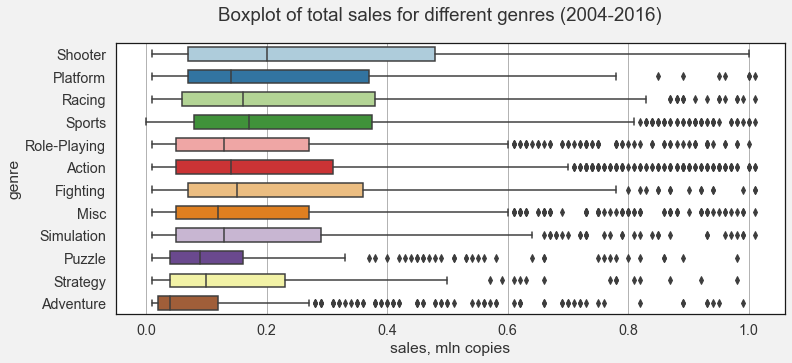

In [52]:
# строим бохплоты для суммарных продаж разных игр для различных современных платформ
# сортировка жанров на графике - по убыванию продаваемости жанров за актуальный период
plot_sales_boxplot(data=clean_outlierts(data_actual, 'total_sales'), x='total_sales', y='genre', order=genre_order,
                  title='Boxplot of total sales for different genres (2004-2016)')

Боксплоты подтвержают налюдения, описанные выше.

[вернуться к оглавлению](#table_of_contents)

<a name="portret"></a>

## 3. Составление "портрета пользователя" каждого региона

Для начала посмотрим, как по годам распределяются продажи игр в разных регионах:

In [53]:
sales_by_year_regions = (data.pivot_table(index='year_of_release',
                                         values=['na_sales', 'eu_sales', 'jp_sales','other_sales', 'total_sales'],
                                         aggfunc='sum')
                         .reset_index()
                         .melt('year_of_release', var_name='region',  value_name='sales'))

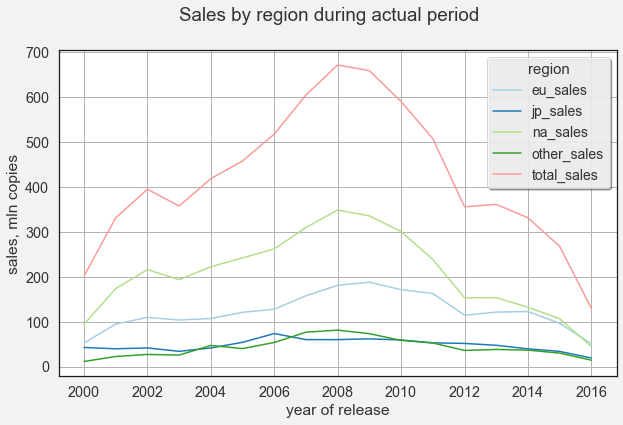

In [54]:
sns.lineplot(data = sales_by_year_regions,
             x='year_of_release',
             y='sales',
             hue='region')
plt.xlabel('year of release')
plt.ylabel('sales, mln copies')
plt.suptitle('Sales by region during actual period')
plt.show()

Видно, что самое больше количество видеоигр всегда продавалось в Северной Америке, на втором месте Европа. В японии продается примерно столько же игр, сколько во всем остальном мире.

*Определим для пользователя каждого региона (NA, EU, JP):*
* *Самые популярные платформы (топ-5)*
* *Самые популярные жанры (топ-5)*
* *Как влияет рейтинг (возрастная категория) ESRB на продажи в отдельном регионе*

<a name="platforms"></a>
### Сравнение популярности и продаваемости платформ в регионах (EU, NA, JP)

In [55]:
col_names = ['total_sales', 'game_mean_sales']
regions_top5_sales_platforms = []
regions_top5_mean_sales_platforms = []
for region in ['eu', 'na', 'jp']:
    # группируем данные по платформе, подсчитывая суммарные продажи игр каждый платформы в регионе
    # и среднее число проданных копий для каждой игры платформы (продаваемость)
    region_platform_chart = data_actual.pivot_table(index='platform',
                                                    values=f'{region}_sales',
                                                    aggfunc=['sum', 'mean'])
    # переименуем колонки
    region_platform_chart.columns = col_names
    
    ## делам топ-5 по суммарным продажам
    # сортируем по убыванию суммарных продаж и возьмем топ-5
    region_sales_platform_chart = region_platform_chart.sort_values(by='total_sales', ascending=False).head()
    # сделаем мультииндексы
    tuples = list(zip([f'{region}_sales_top-5']*5, region_sales_platform_chart.index))
    index = pd.MultiIndex.from_tuples(tuples, names=['region', 'platform'])
    region_sales_platform_chart.index = index
    # запишем в список
    regions_top5_sales_platforms.append(region_sales_platform_chart)
    
    ## делаем топ-5 по средним продажам игры (продаваемость)
    # сортируем по убыванию средней продаваемогсти платформ и возьмем топ-5
    region_mean_sales_platform_chart = region_platform_chart.sort_values(by='game_mean_sales', ascending=False).head()
    # сделаем мультииндексы
    tuples = list(zip([f'{region}_mean_sales_top-5']*5, region_mean_sales_platform_chart.index))
    index = pd.MultiIndex.from_tuples(tuples, names=['region', 'platform'])
    region_mean_sales_platform_chart.index = index
    # запишем в список
    regions_top5_mean_sales_platforms.append(region_mean_sales_platform_chart)

regions_top5_sales_platforms = pd.concat(regions_top5_sales_platforms, axis=0)
regions_top5_mean_sales_platforms = pd.concat(regions_top5_mean_sales_platforms, axis=0)

In [56]:
# топ-5 платформ по популярности (по суммарным продажам) в регионах
regions_top5_sales_platforms

total_sales  game_mean_sales
region         platform                              
eu_sales_top-5 PS3            327.21         0.250544
               X360           268.32         0.217792
               Wii            258.32         0.200871
               DS             188.41         0.088873
               PS4            141.09         0.359923
na_sales_top-5 X360           595.74         0.483555
               Wii            486.87         0.378593
               PS3            390.13         0.298721
               DS             380.31         0.179392
               PS4            108.74         0.277398
jp_sales_top-5 DS             175.00         0.082547
               3DS            100.62         0.196523
               PS3             79.41         0.060804
               PSP             75.88         0.063604
               Wii             68.28         0.053095

Европа и Северная Америка обладают **одинаковым набором платформ** в топ-5 (с небольшими перестановками) популярных платформ. Япония отличается сильнее, например, самые популярные в Европе и Северной Америке **X360** и **PS4** в Японии вообще не входят в топ-5. Зато **DS** и **3DS** в Японии занимают самые высокие позиции.

In [57]:
# топ-5 платформ по продаваемости (по среднему числу проданных копий игры) в регионах
regions_top5_mean_sales_platforms

total_sales  game_mean_sales
region              platform                              
eu_mean_sales_top-5 PS4            141.09         0.359923
                    PS3            327.21         0.250544
                    X360           268.32         0.217792
                    XOne            51.59         0.208866
                    Wii            258.32         0.200871
na_mean_sales_top-5 X360           595.74         0.483555
                    Wii            486.87         0.378593
                    XOne            93.12         0.377004
                    PS3            390.13         0.298721
                    PS4            108.74         0.277398
jp_mean_sales_top-5 3DS            100.62         0.196523
                    WiiU            13.01         0.088503
                    DS             175.00         0.082547
                    PSP             75.88         0.063604
                    PS3             79.41         0.060804

В рейтинге **продаваемости в Европе** лидирует развивающаяся перспективаня платформа **PS4**. Дополнительно в Европе хорошую продаваемость игр показывает платформа **XOne** (тоже перспективная, развивающаяся), хотя по популярности она не попала в топ-5. **В Северной Америке** сходная ситуация. А вот **DS** в среднем продает не много копий игр, поэтому в топ-5 по продаваемости этих регионов не вошла, хотя суммарные продажы дают ей 4 место в рейтингах Европы и Америки.

Рейтинг **в Японии** отличаются от двух других регионов и по продаваемости тоже: здесь снова **DS** и **DS3** в первых строчка рейтинга.

[вернуться к оглавлению](#table_of_contents)

<a name="games"></a>
### Выявление популярнейших игр в регионах (EU, NA, JP)

Построим боксплоты значений для топ-5 по суммарным продажам платформ:

In [58]:
# строить боксплоты будем в порядке убывания суммарных продаж
eu_platform_order = regions_top5_sales_platforms.loc['eu_sales_top-5'].index.tolist()
na_platform_order = regions_top5_sales_platforms.loc['na_sales_top-5'].index.tolist()
jp_platform_order = regions_top5_sales_platforms.loc['jp_sales_top-5'].index.tolist()
eu_platform_order, na_platform_order, jp_platform_order

(['PS3', 'X360', 'Wii', 'DS', 'PS4'],
 ['X360', 'Wii', 'PS3', 'DS', 'PS4'],
 ['DS', '3DS', 'PS3', 'PSP', 'Wii'])

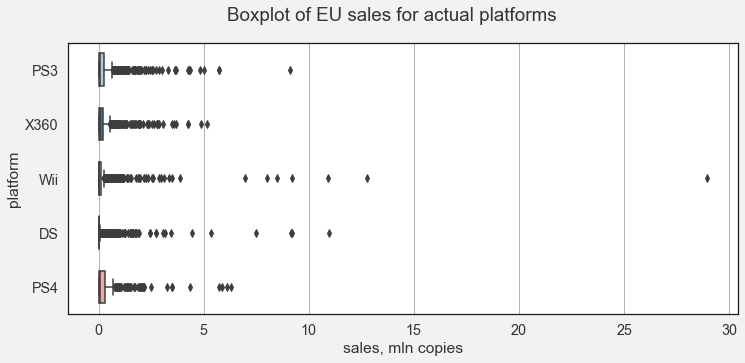

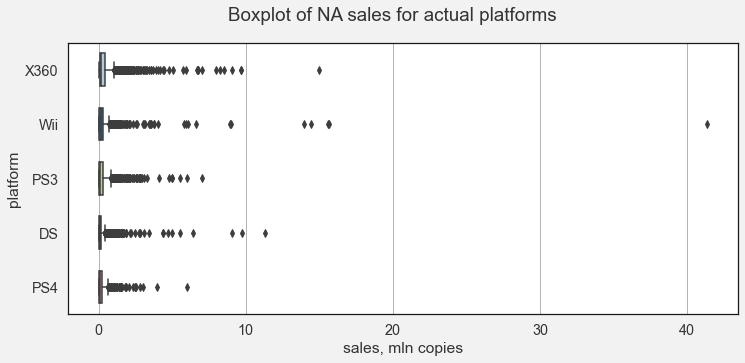

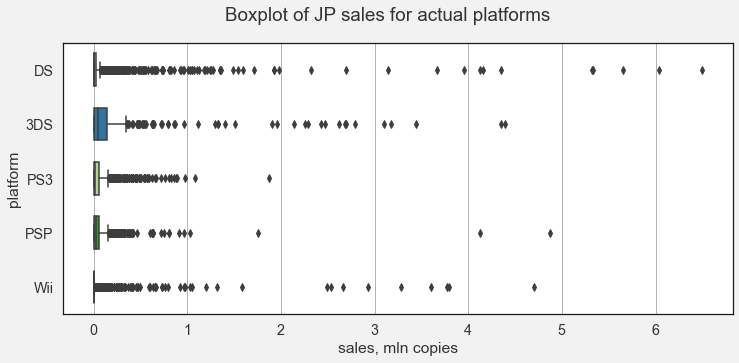

In [59]:
plot_sales_boxplot(data=data_actual.query('platform in @eu_platform_order'),
                   x='eu_sales', y='platform', order=eu_platform_order,
                   title='Boxplot of EU sales for actual platforms')

plot_sales_boxplot(data=data_actual.query('platform in @na_platform_order'),
                   x='na_sales', y='platform', order=na_platform_order,
                   title='Boxplot of NA sales for actual platforms')

plot_sales_boxplot(data=data_actual.query('platform in @jp_platform_order'),
                   x='jp_sales', y='platform', order=jp_platform_order,
                   title='Boxplot of JP sales for actual platforms')

В столбцах `'eu_sales'` и `'na_sales'` есть какие-то очень сильные выброыс со значение около 30 b 40 млн.копий. Посмотрим на них:

In [60]:
data.sort_values(by='eu_sales', ascending=False).head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN,24.67
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
19,Brain Age: Train Your Brain in Minutes a Day,DS,2005,Misc,4.74,9.20,4.16,2.04,77.0,7.9,E,20.14


In [61]:
data.sort_values(by='na_sales', ascending=False).head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
14,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,61.0,6.3,E,21.82
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32


И снова это **Wii Sports**, который по всему миру тоже был самым популярным - теперь понятно почему, если и в Европе, и в Америке он самый популярный! Так же, как и во всем мире, 4 из топ-5 продаваемых игр в Европе - на платформе Wii (в Америке 3 из 5). Второе место по популярности игр в ибоих регионах достается **Mario Kart Wii**.

В Японии население меньше, чем в Европе/Америке, поэтому и цифры продаж там поменьше. Однако, сильных выбросов тут больше, нет какого-то одного очень выдающегося. Посмотрим так же на топ-5 продаваемых игр.

In [62]:
data.sort_values(by='jp_sales', ascending=False).head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
20,Pokemon Diamond/Pokemon Pearl,DS,2006,Role-Playing,6.38,4.46,6.04,1.36,NaN,NaN,NaN,18.24
27,Pokemon Black/Pokemon White,DS,2010,Role-Playing,5.51,3.17,5.65,0.80,NaN,NaN,NaN,15.13
25,Pokemon Ruby/Pokemon Sapphire,GBA,2002,Role-Playing,6.06,3.90,5.38,0.50,NaN,NaN,NaN,15.84
43,Animal Crossing: Wild World,DS,2005,Simulation,2.50,3.45,5.33,0.86,86.0,8.7,E,12.14


Снова видим, как отличается ситация в Японии: 4/5 популярных игр - для платформы **DS**, причем преобладают родные японцам Покемоны.

Чтобы на боксплотах было лучше видно распределение, удалим выбросы по колонкам продаж:

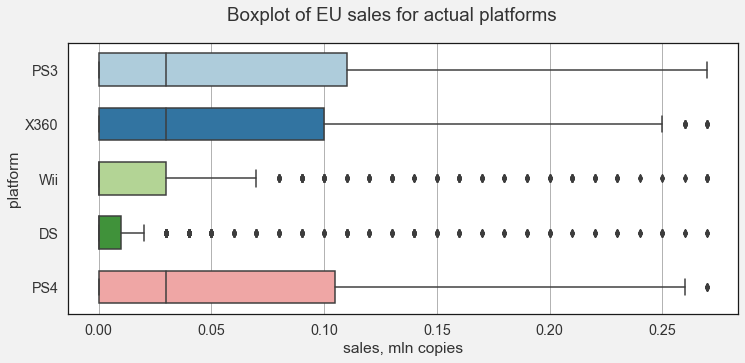

In [63]:
plot_sales_boxplot(data=clean_outlierts(data_actual, 'eu_sales').query('platform in @eu_platform_order'),
                   x='eu_sales', y='platform', order=eu_platform_order,
                   title='Boxplot of EU sales for actual platforms')

На картинках боксплоты для разных платформ находятся в порядке убывания суммарных продаж (популярности).

Несмотря на то, что данные платформы - самые популярные в Европе, для Wii и DS существует большое количество игр, для которых не было продано ни одной копии в Европе (медиана "прилипла" к нижней/левой стенке ящика с усами).

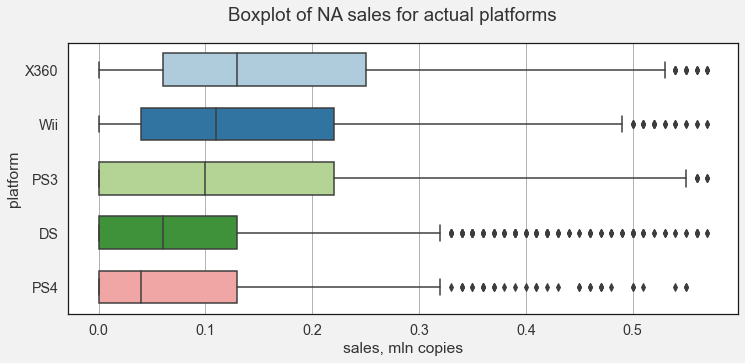

In [64]:
plot_sales_boxplot(data=clean_outlierts(data_actual, 'na_sales').query('platform in @na_platform_order'),
                   x='na_sales', y='platform', order=na_platform_order,
                   title='Boxplot of NA sales for actual platforms')


Для северной Америки рейтинги по популярности и продаваемости похоже сильнее, что видно и на боксплоте тоже.

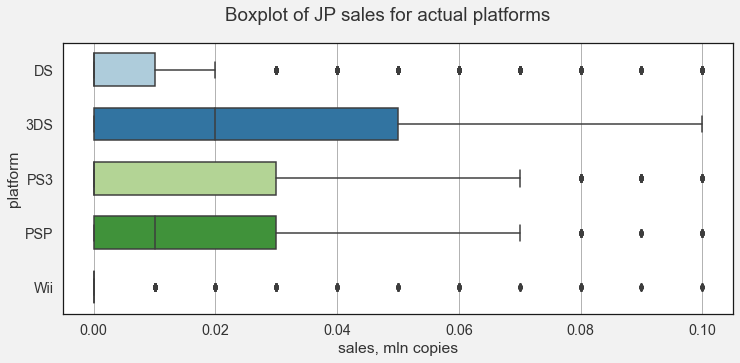

In [65]:
plot_sales_boxplot(data=clean_outlierts(data_actual, 'jp_sales').query('platform in @jp_platform_order'),
                   x='jp_sales', y='platform', order=jp_platform_order,
                   title='Boxplot of JP sales for actual platforms')

В Японии для самой популярной платформы **DS** оказывается, было много игр с нулевыми продажами, зато и больших выбросов тоже очень много (либо очень популярные игры, либо совсем нет, средних мало).

[вернуться к оглавлению](#table_of_contents)

<a name="region_genres"></a>
### Сравнение популярности и продаваемости жанров в регионах (EU, NA, JP)

In [66]:
col_names = ['total_sales', 'game_mean_sales']
regions_top5_sales_genres = []
regions_top5_mean_sales_genres = []
for region in ['eu', 'na', 'jp']:
    # группируем данные по жанру, подсчитывая суммарные продажи игр каждого жанра в регионе
    # и среднее число проданных копий для каждой игры жанра (продаваемость)
    region_genres_chart = data_actual.pivot_table(index='genre',
                                                    values=f'{region}_sales',
                                                    aggfunc=['sum', 'mean'])
    # переименуем колонки
    region_genres_chart.columns = col_names
    
    ## делам топ-5 по суммарным продажам
    # сортируем по убыванию суммарных продаж и возьмем топ-5
    region_sales_genres_chart = region_genres_chart.sort_values(by='total_sales', ascending=False).head()
    # сделаем мультииндексы
    tuples = list(zip([f'{region}_sales_top-5']*5, region_sales_genres_chart.index))
    index = pd.MultiIndex.from_tuples(tuples, names=['region', 'genre'])
    region_sales_genres_chart.index = index
    # запишем в список
    regions_top5_sales_genres.append(region_sales_genres_chart)
    
    ## делаем топ-5 по средним продажам игры (продаваемость)
    # сортируем по убыванию средней продаваемогсти жанра и возьмем топ-5
    region_mean_sales_genres_chart = region_genres_chart.sort_values(by='game_mean_sales', ascending=False).head()
    # сделаем мультииндексы
    tuples = list(zip([f'{region}_mean_sales_top-5']*5, region_mean_sales_genres_chart.index))
    index = pd.MultiIndex.from_tuples(tuples, names=['region', 'genre'])
    region_mean_sales_genres_chart.index = index
    # запишем в список
    regions_top5_mean_sales_genres.append(region_mean_sales_genres_chart)

regions_top5_sales_genres = pd.concat(regions_top5_sales_genres, axis=0)
regions_top5_mean_sales_genres = pd.concat(regions_top5_mean_sales_genres, axis=0)

In [67]:
# топ-5 жанров по популярности (по суммарным продажам) в регионах
regions_top5_sales_genres

total_sales  game_mean_sales
region         genre                                     
eu_sales_top-5 Action             327.76         0.156299
               Sports             234.33         0.214392
               Shooter            219.07         0.370051
               Misc               147.27         0.128396
               Racing             118.34         0.249662
na_sales_top-5 Action             497.98         0.237473
               Sports             369.23         0.337813
               Shooter            363.14         0.613412
               Misc               275.78         0.240436
               Role-Playing       180.18         0.210000
jp_sales_top-5 Role-Playing       164.29         0.191480
               Action              97.82         0.046648
               Misc                69.36         0.060471
               Sports              42.85         0.039204
               Platform            37.38         0.119045

*Misc - жанр "прочее", о нем не говорим, он берет количеством*

Топ-3 жанров в Европе и Северной Америке полнотсью совпадают - **Action**, **Sports**, **Shooter** (как и по всему миру). Единственное отличие, что в Европе бльше любят гонки **Racing**, а в Америке ролевые игры **Role-Playing**.

Япония здесь снова отличается сильнее, например, японцы больше всего любят ролевые игры **Role-Playing**, хотя как и игроки в Европе и Америке не против "активных" игр жанров **Action** и **Sports**.

In [68]:
# топ-5 жанров по продаваемости (по среднему числу проданных копий игры) в регионах
regions_top5_mean_sales_genres

total_sales  game_mean_sales
region              genre                                     
eu_mean_sales_top-5 Shooter            219.07         0.370051
                    Platform            83.75         0.266720
                    Racing             118.34         0.249662
                    Sports             234.33         0.214392
                    Action             327.76         0.156299
na_mean_sales_top-5 Shooter            363.14         0.613412
                    Platform           138.42         0.440828
                    Sports             369.23         0.337813
                    Racing             140.45         0.296308
                    Fighting            86.39         0.246125
jp_mean_sales_top-5 Role-Playing       164.29         0.191480
                    Platform            37.38         0.119045
                    Fighting            26.70         0.076068
                    Simulation          31.00         0.062000
                    Misc                69.36         0.060471

Однако **по среднему число проданных копий лидируют** в Европе и Америке стрелялки (**Shooter**) и бродилки (**Platform**), как и по всему миру. Японцы, оказывается тоже не прочь побродить и по продаваемости жанр **Platform** здесь занимает второе место.

Посмотрим на боксплотах на распределение значений проданных копий игр разных жанров по регионам:

In [69]:
# строить боксплоты будем в порядке убывания суммарных продаж
eu_genre_order = regions_top5_sales_genres.loc['eu_sales_top-5'].index.tolist()
na_genre_order = regions_top5_sales_genres.loc['na_sales_top-5'].index.tolist()
jp_genre_order = regions_top5_sales_genres.loc['jp_sales_top-5'].index.tolist()
eu_genre_order, na_genre_order, jp_genre_order

(['Action', 'Sports', 'Shooter', 'Misc', 'Racing'],
 ['Action', 'Sports', 'Shooter', 'Misc', 'Role-Playing'],
 ['Role-Playing', 'Action', 'Misc', 'Sports', 'Platform'])

На картинках боксплоты для разных платформ находятся в порядке убывания суммарных продаж (популярности).

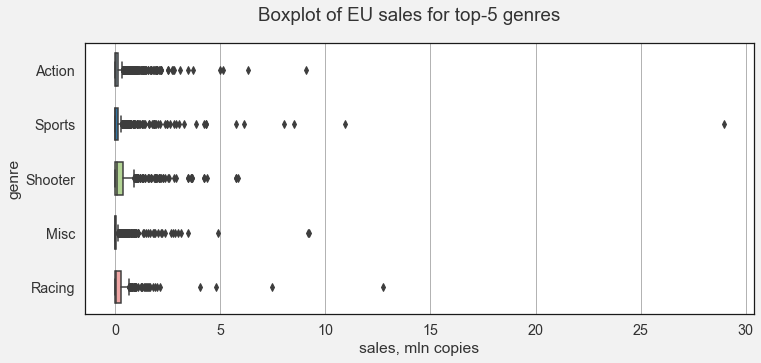

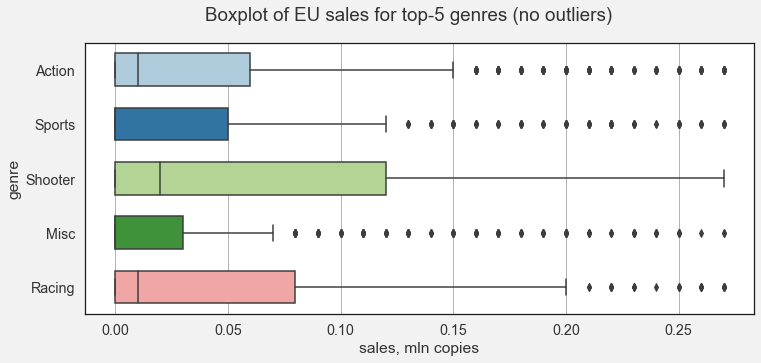

In [70]:
plot_sales_boxplot(data=data_actual.query('genre in @eu_genre_order'),
                   x='eu_sales', y='genre', order=eu_genre_order,
                   title='Boxplot of EU sales for top-5 genres')

plot_sales_boxplot(data=clean_outlierts(data_actual, 'eu_sales').query('genre in @eu_genre_order'),
                   x='eu_sales', y='genre', order=eu_genre_order,
                   title='Boxplot of EU sales for top-5 genres (no outliers)')

Снова видим выброс под 30 млн.копий - Wii Sports. Хотя других игр жанра **Sports** - достаточно много с малым числом продаж в Европе. И вообще эта тенденция явно наблюдается: **супер-популярных игр мало, а непопулярных - много**.

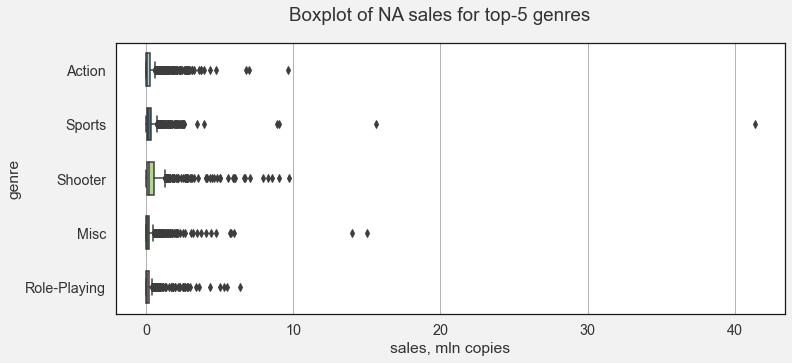

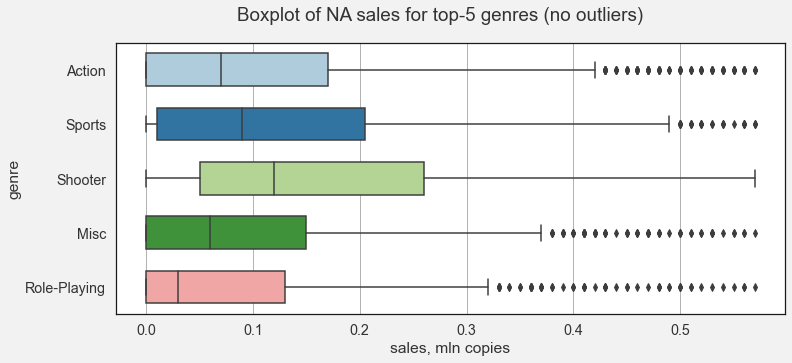

In [71]:
plot_sales_boxplot(data=data_actual.query('genre in @na_genre_order'),
                   x='na_sales', y='genre', order=na_genre_order,
                   title='Boxplot of NA sales for top-5 genres')

plot_sales_boxplot(data=clean_outlierts(data_actual, 'na_sales').query('genre in @na_genre_order'),
                   x='na_sales', y='genre', order=na_genre_order,
                   title='Boxplot of NA sales for top-5 genres (no outliers)')

В Северной Америке стрелялки продаются лучше, чем все остальное, что снова подтвержает боксплот.

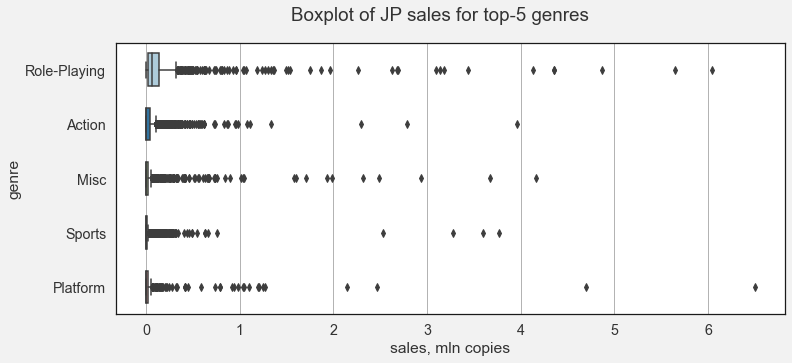

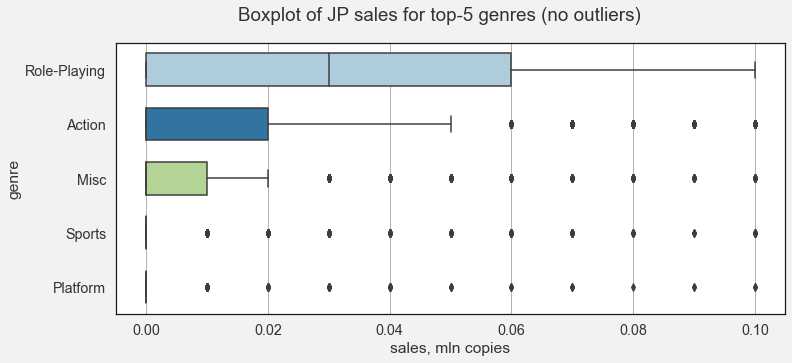

In [72]:
plot_sales_boxplot(data=data_actual.query('genre in @jp_genre_order'),
                   x='jp_sales', y='genre', order=jp_genre_order,
                   title='Boxplot of JP sales for top-5 genres')

plot_sales_boxplot(data=clean_outlierts(data_actual, 'jp_sales').query('genre in @jp_genre_order'),
                   x='jp_sales', y='genre', order=jp_genre_order,
                   title='Boxplot of JP sales for top-5 genres (no outliers)')

Все-таки не во всех бродилках японцы любят побродить - очень много с нулевыми продажами, однако есть некоторые успешные. Как уже было сказано - много успешных ролевых, которые как активно производятся, так активно и покупаются (популярность и продаваемость в Японии у этих игр самая большая).

[вернуться к оглавлению](#table_of_contents)

<a name="esrb"></a>
### Сравнение популярности и продаваемости игр различных возрастных категорий

Посмотрим, как продаются игры разных возрастных категорий в регионах.

Категории у **Entertainment Software Rating Board (ESRB)** следующие:
* **EC** («Early childhood») — Для детей младшего возраста
* **T** («Teen») — Подросткам
* **E10+** («Everyone 10 and older») — Для всех от 10 лет и старше
* **M** («Mature») — Для взрослых
* **E** («Everyone») — Для всех
* **RP** («Rating Pending») — Рейтинг ожидается (*строчки этой категории не попави в рассматриваемый промежут современных платформ*)

In [73]:
col_names = ['total_sales', 'game_mean_sales']
regions_category_sales_chart = []
for region in ['eu', 'na', 'jp']:
    # группируем данные по категории, подсчитывая суммарные продажи категории в регионе
    # и среднее число проданных копий категории (продаваемость)
    region_category_chart = data_actual.pivot_table(index='rating',
                                                    values=f'{region}_sales',
                                                    aggfunc=['sum', 'mean'])
    # переименуем колонки
    region_category_chart.columns = col_names
    
    ## делам топ-5 по суммарным продажам
    # сортируем по убыванию суммарных продаж и возьмем топ-5
    regions_category_sales = region_category_chart.sort_values(by='total_sales', ascending=False)
    # сделаем мультииндексы
    tuples = list(zip([f'{region}_sales_top-5']*5, regions_category_sales.index))
    index = pd.MultiIndex.from_tuples(tuples, names=['region', 'rating'])
    regions_category_sales.index = index
    # запишем в список
    regions_category_sales_chart.append(regions_category_sales)

regions_category_sales_chart = pd.concat(regions_category_sales_chart, axis=0)

In [74]:
# топ-5 категорий по популярности (по суммарным продажам) в регионах
regions_category_sales_chart

total_sales  game_mean_sales
region         rating                              
eu_sales_top-5 E            468.15         0.208996
               M            358.46         0.423712
               T            194.62         0.133851
               E10+         160.07         0.144468
               EC             0.00         0.000000
na_sales_top-5 E            794.95         0.354888
               M            548.07         0.647837
               T            377.38         0.259546
               E10+         295.97         0.267121
               EC             1.23         0.307500
jp_sales_top-5 E            142.24         0.063500
               T             77.55         0.053336
               M             42.18         0.049858
               E10+          36.99         0.033384
               EC             0.00         0.000000

Из рейтинга видно, что наибольшее суммарное количество копий у категории **Е** (для всех), затем игры для взрослых (**М**), затем для тинейджеров (**Т**). Игры для малышей в Европе и Японии совсем не продаются, а вот в Северной Америке - немного. Но если посмотреть на данные о современных играх, их там всего 4 штуки.

In [75]:
data_actual[data_actual['rating'] == 'EC'].shape

(4, 12)

А ESRB не то, чтобы исправно расставляет рейтинги -- много пропущенных значений. Хотя возможно, просто ошибка выгрузки данных.

In [76]:
data['rating'].isnull().sum()

4807

[вернуться к оглавлению](#table_of_contents)

<a name="tests"></a>
## 4. Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Так как выше мы рассматривали только актуальные платформы, а PC таковой не посчитали, надо взять данные по ней тоже из таблицы, где были отсечены только годы раньше 1990:

In [77]:
# отделим выборки, выбросив пропущенные значения
xone = data[data['platform'] == 'XOne']['user_score'].dropna()
pc = data[data['platform'] == 'PC']['user_score'].dropna()
print(len(xone), len(pc))

182 734


    H0: средние пользовательские рейтинги платформ Xbox One и PC равны.
    H1: средние пользовательские рейтинги платформ Xbox One и PC не равны (двусторонняя альтернатива).
Считаем, что пользовательские рейтинги приходят из двух разных генеральных совокупностей (**одни люди играют на компьтере, другие на приставке**), то есть **выборки независимы**.

Будем использовать **t-критерий Стьюдента** для проверки **гипотезы о равенстве средних двух независимых выборок**.

Но прежде чем произвести проверку гипотезы через t-критерий Стьюдента проведем **проверку дисперсии выборок**, чтобы понять с каким параметром `equal_var` использовать метод проверки `ttest_ind` (по дефолту True). Для этого нужно сначала **проверить выборки на нормальность**, чтобы знать, какой тест Бартлета или Левене использовать.

Посмотрим на гистограммы выборок:

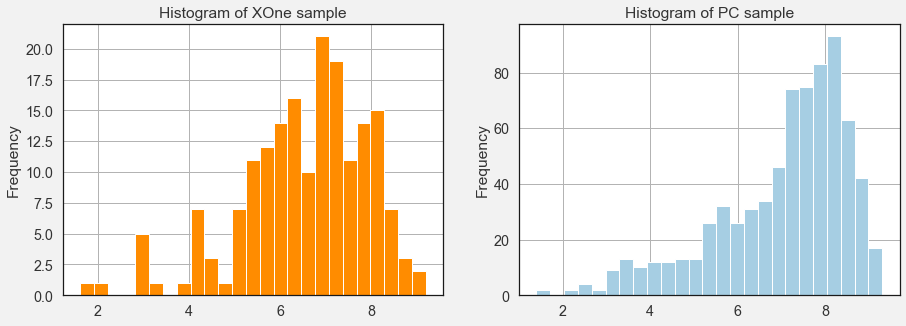

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
xone.sort_values().plot(kind='hist', bins=25, color=colors[0], ax=ax[0])
ax[0].set_title('Histogram of XOne sample')
pc.sort_values().plot(kind='hist', bins=25, ax=ax[1])
ax[1].set_title('Histogram of PC sample')
plt.show()

In [79]:
# тест на нормальность выборок (нулевая гипотеза - выборка нормально распределена)
alpha=0.05

s, pvalue = st.normaltest(xone)
print('p-значение:', pvalue)
if (pvalue < alpha):
    print(bold('Отвергаем нулевую гипотезу на уровне pначимости'), alpha)
else:
    print(bold('Не получилось отвергнуть нулевую гипотезу'), alpha)
    
s, pvalue = st.normaltest(pc)
print('p-значение:', pvalue)
if (pvalue < alpha):
    print(bold('Отвергаем нулевую гипотезу на уровне pначимости'), alpha)
else:
    print(bold('Не получилось отвергнуть нулевую гипотезу'), alpha)

p-значение: 1.1534936880652902e-05
Отвергаем нулевую гипотезу на уровне pначимости 0.05
p-значение: 3.3376771355439974e-25
Отвергаем нулевую гипотезу на уровне pначимости 0.05


Генеральные совокупности распределены не нормально. Выбираем **тест Левене** для проверки дисперсий выборок на равенство:

In [80]:
print('Дисперсия значений рейтинга платформы XOne {:.2f}, рейтинга платформы PC {:.2f}'.format(xone.var(), pc.var()))

Дисперсия значений рейтинга платформы XOne 1.91, рейтинга платформы PC 2.31


In [81]:
alpha=0.05
# тест на равенство дисперсий (нулевая гипотеза - дисперсии равны)
s, pvalue = st.levene(xone, pc)
print('p-значение:', pvalue)
if (pvalue < alpha):
    print(bold('Отвергаем нулевую гипотезу на уровне pначимости'), alpha)
else:
    print(bold('Не получилось отвергнуть нулевую гипотезу'), alpha)

p-значение: 0.30979234107221576
Не получилось отвергнуть нулевую гипотезу 0.05


Критерий Левене не отвергает нулевую гипотезу о равенстве дисперсий генеральных совокупностей, из которых были взяты выборки. Теперь с помощью **t-критерия Стьюдента** проверим **гипотезу о равенстве средних** с параметром `equal_var=True`:

In [82]:
# тест на равенство средних 
s, pvalue = st.ttest_ind(xone, pc, equal_var=True)
alpha = 0.05
print('p-значение:', pvalue)
if (pvalue < alpha):
    print(bold('Отвергаем нулевую гипотезу на уровне pначимости'), alpha)
else:
    print(bold('Не получилось отвергнуть нулевую гипотезу'), alpha)

p-значение: 3.750185722417337e-05
Отвергаем нулевую гипотезу на уровне pначимости 0.05


На уровне значимости 0.05 отвергаем нулевую гипотезу о равенстве средних, то есть **средние пользовательские рейтинги платформ PC и X360 отличаются**.

###  Средние пользовательские рейтинги жанров Action и Sports различаются

Проведем тестирование аналогично тому, что описано выше.

In [83]:
# отделим выборки, выбросив пропущенные значения
action = data[data['genre'] == 'Action']['user_score'].dropna()
sports = data[data['genre'] == 'Sports']['user_score'].dropna()
print(len(action), len(sports))

1781 1079


    H0: средние пользовательские рейтинги жанров Action и Sports равны.
    H1: средние пользовательские рейтинги жанров Action и Sports не равны (двусторонняя альтернатива).

Считаем, что пользовательские рейтинги приходят из двух разных генеральных совокупностей (одни люди любят Action, другие -- Sports), то есть выборки независимы.

Будем использовать **t-критерий Стьюдента** для проверки гипотезы о равенстве средних двух независимых выборок.

Но прежде чем произвести проверку гипотезы через t-критерий Стьюдента проведем **проверку дисперсии** выборок, чтобы понять с каким параметром `equal_var` использовать метод проверки `ttest_ind` (по дефолту True). Для этого нужно сначала **проверить выборки на нормальность**, чтобы знать, какой тест Бартлета или Левене использовать.

Посмотрим на гистограммы выборок:

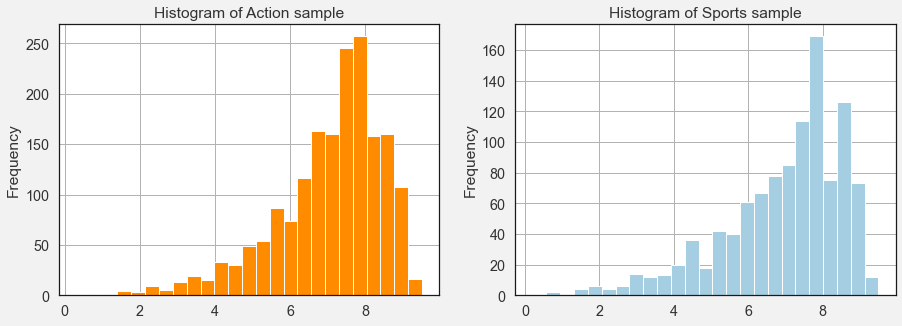

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
action.sort_values().plot(kind='hist', bins=25, color=colors[0], ax=ax[0])
ax[0].set_title('Histogram of Action sample')
sports.sort_values().plot(kind='hist', bins=25, ax=ax[1])
ax[1].set_title('Histogram of Sports sample')
plt.show()

In [85]:
# тест на нормальность выборок (нулевая гипотеза - генеральная совокупность распределена нормально)
alpha=0.05

s, pvalue = st.normaltest(action)
print('p-значение:', pvalue)
if (pvalue < alpha):
    print(bold('Отвергаем нулевую гипотезу на уровне pначимости'), alpha)
else:
    print(bold('Не получилось отвергнуть нулевую гипотезу на уровне pначимости '), alpha)
    
s, pvalue = st.normaltest(sports)
print('p-значение:', pvalue)
if (pvalue < alpha):
    print(bold('Отвергаем нулевую гипотезу на уровне pначимости'), alpha)
else:
    print(bold('Не получилось отвергнуть нулевую гипотезу на уровне pначимости '), alpha)

p-значение: 2.8936699123961717e-64
Отвергаем нулевую гипотезу на уровне pначимости 0.05
p-значение: 1.495166966129326e-39
Отвергаем нулевую гипотезу на уровне pначимости 0.05


Генеральные совокупности распределены не нормально. Выбираем **тест Левене** на равенство дисперсий:

In [86]:
print('Дисперсия значений рейтинга жанра Action {:.2f}, рейтинга  жанра Sports {:.2f}'.format(action.var(), sports.var()))

Дисперсия значений рейтинга жанра Action 2.02, рейтинга  жанра Sports 2.62


In [87]:
alpha=0.05
# тест на равенство дисперсий (нулевая гипотеза - дисперсии равны)
s, pvalue = st.levene(xone, pc)
print('p-значение:', pvalue)
if (pvalue < alpha):
    print(bold('Отвергаем нулевую гипотезу на уровне pначимости'), alpha)
else:
    print(bold('Не получилось отвергнуть нулевую гипотезу на уровне pначимости '), alpha)

p-значение: 0.30979234107221576
Не получилось отвергнуть нулевую гипотезу на уровне pначимости  0.05


Критерий Левене отвергает нулевую гипотезу о равенстве дисперсий генеральных совокупностей, из которых были взяты выборки. Теперь с помощью **t-критерия Стьюдента** проверим **гипотезу о равенстве средних** с параметром `equal_var=True`:

In [88]:
# тест на равенство средних 
s, pvalue = st.ttest_ind(xone, pc, equal_var=True)
alpha = 0.05
print('p-значение:', pvalue)
if (pvalue < alpha):
    print(bold('Отвергаем нулевую гипотезу на уровне pначимости'), alpha)
else:
    print(bold('Не получилось отвергнуть нулевую гипотезу'), alpha)

p-значение: 3.750185722417337e-05
Отвергаем нулевую гипотезу на уровне pначимости 0.05


На уровне значимости 0.05 отвергаем нулевую гипотезу о равенстве средних, то есть **средние пользовательские рейтинги жанров Action и Sports отличаются**.

[вернуться к оглавлению](#table_of_contents)

<a name="conclusions"></a>
## 5. Общие выводы

1. Выявлен период начала активного роста популярности видеоигр - 1990 год; максимума своей популярности видеоигры достигают к 2008 году, а затем их востребованность плавно снижается.

2. Определена средняя длительность периода, в течение которого платформа остается востребованной, она составляет примерно 10 лет.

3. Обозначено две метрики успеха игр определенной платформы/жанра:
    * **Популярность** - позиция в рейтинге по суммарным продажам, которая определяется суммарным числом проданных копий игр платформы/жанра и общим количеством игр платформы/жанра.
    * **Продаваемость** суммарное количество проданных копий, деленное на общее количество игра платформы/жанра, то есть среднее число копий, которое продается с этой платформы/жанра. Этот показатель лучше позволяет сравнивать платформы и жанры между собой.

4. Самые оппулярные современные (2004-2016 гг) платформы: **X360, PS3, Wii**, DS, PS4, PSP, 3DS, XOne, Wii', PSV (перечислены в порядке убывания суммарных продаж за весь период по всему миру).

5. При этом топовые по суммарным продажам платформы - X360, PS3, Wii. в рейтинге продаваемости уступают развивающейся перспективной платформе **PS4** - PS4 в среднем продает 0.8 млн копий игры. Другая перспективная платформа **XOne** находится на 5-ой строчке рейтинга продаваемости и выпускает 0.65 млн.копий на игру.

6. Самая популярная игра в мире **Wii Sports** - по всему миру было куплено 80 млн копий. В топе-5 популярных игр 4 игры разработаны на платформе Wii.

7. Довольно много игр с пользовательским рейтингом 7+ и оценкой критиков 70+. Что говорит о том, выпускаемые игры, в основном, нравятся любителям видеоигр. При этом оценки критиков линейно коррелируют с популярностью игры (коэф.корр. 0.4 для платформы Х360, например). Пользователи же ставят свои оценки более случайно, опираясь на свои ощущения.

8. Анализ популярности различных жанров показал, что самые распространенные жанры -**Action, Sports и Shooter**. Однако эти жанры по продаваемости все-таки уступают стрелялкам (**Shooter**), бродилкам (**Platform**) и гонкам (**Racing**). То есть последних выпускают меньше разных, но продаются они лучше. Стратегии (**Strategy**), головоломки (**Puzzle**) и прилючения (квесты) (**Adventure**) в обоих рейтингах занмают последние строчки.

9. При анализе продаваемости и популярности разных платформ и жанро в следущих регионах Европа, Северная Америка и Япония, оказалось, то пользователь из Японии сильно отличается от остальных:
    * Так Европа и Северная Америка обладают **одинаковым набором платформ** в топ-5 (с небольшими перестановками) популярных платформ - **PS3, X360, Wii, DS, PS4**. В Японии же X360 и PS4 вообще не входят в топ-5. Зато **DS** и **3DS** в Японии занимают самые высокие позиции.
    * Что касается продаваемости, то **в Европе** лидирует развивающаяся перспективаня платформа **PS4**. Дополнительно в Европе хорошую продаваемость игр показывает платформа **XOne** (тоже перспективная, развивающаяся), хотя по популярности она не попала в топ-5. **В Северной Америке** сходная ситуация. **В Японии** по продаваемости снова **DS** и **DS3** в первых строчка рейтинга. Однако, для DS было обнаружено много игр с нулевыми продажами, зато и больших выбросов тоже очень много (либо очень популярные игры, либо совсем нет, средних мало).
    * Самые популярные игры в Европе и Северной Америке - от Wii с бесспорным чемпионом **Wii Sports**. А Японии: 4/5 популярных игр - для платформы DS, причем преобладают родные японцам Покемоны.
    * Что касается популярности жанров, то в Европе и Северной Америке они полностью совпадают - **Action**, **Sports**, **Shooter** (как и по всему миру). Японцы больше всего любят ролевые игры **Role-Playing**.
    * По среднему число проданных копий лидируют в Европе и Америке стрелялки (**Shooter**) и бродилки (**Platform**), как и по всему миру. Японцы, оказывается тоже не прочь побродить и по продаваемости жанр **Platform** здесь занимает второе место (первое, конечно, у **Role-Playing**).

10. Самые популярные и продаваемые видеоигры во все регионах  относятся к категориям ESRB "Е", что означает "для всех", и "М" ("для взрослых").
    
11. Общий вывод о популярности и продаваемости игр: **непопулярных игр - много, а  супер-популярных - мало**, но иногда они настолько выделяются, что тянут среднее значение сильно-сильно вверх.

12. Проверка статистических гипотез **t-критерием Стьюдента на уровне доверия 5%** показала, что 
    * На основании предоставленной выборки можно сказать, что средние пользовательские рейтинги платформ PC и X360 отличаются.
    * При этом средние пользовательские рейтинги жанров Action и Sports тоже отличаются.
    
13. Из полученых выводов можно здесь некоторые умозрительные прогнозы на счет востребованности игр разных платформ, жанров для разных регионов и в соответствии с этим строить рекламную политику магазина.